### Importing all the python Libraries

In [243]:
import numpy as np
import pandas as pd
import os
import sys
import math
import cv2
import seaborn as sns
import tensorflow as tf

# To calculate accuracy measures and confusion matrix
from sklearn import metrics
# To get Recall and precision values
from sklearn.metrics import classification_report

# !pip install -q pydicom
# After installing pydicom. This is needed to load .dcm files
import pydicom
import pydicom as dcm
from pydicom import dcmread

from matplotlib import pyplot
import matplotlib.patches as patches

from skimage import measure
from skimage.transform import resize

import tensorflow.keras.utils as pltUtil
from tensorflow.keras.utils import Sequence

from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape, BatchNormalization, Activation
from tensorflow.keras.models import Model

from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input 

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input as resnetProcess_input


#### Setting up project path

In [292]:
# Load train set image metadata
dataDirPath = 'C:/Users/ashu/Downloads/rsna-pneumonia-detection-challenge/'

Train_Image_path = dataDirPath + 'stage_2_train_images'

SAVED_FILES_ROOT = 'C:/Users/ashu/Downloads/rsna-pneumonia-detection-challenge/input/reportfiles/'

### Function definations

#### Function to load the metadata from images

In [245]:
class ImageMetadata():
    """Structure to hold image metadata

    Arguments:
        setName -- name of the data set

        file -- file name
    """
    
    def __init__(self, setName, file):
        # print(name, file)
        # dataset name(train or test)
        self.setName = setName
        # image file name
        self.file = file

    def __repr__(self):
        return self.imagePath()

    def imagePath(self):
        return os.path.join(self.setName, self.file) 
    

# function to load image metadada   
def loadImageMetadata(dataSetName):
    """Load image file names from the images from dataset

    Arguments:
        dataSetName -- path of the data set folder
    """
    imageMetadata = []
    for f in os.listdir(dataSetName):
        # Check file extension. Allow only .dcm files.
        ext = os.path.splitext(f)[1]
        if ext == '.dcm' :
            imageMetadata.append(ImageMetadata(dataSetName, f))
            
    # Return an array of filenames
    return np.array(imageMetadata)

#### Functions to load image and patientId(file name) from the given path

In [246]:
def loadImage(path):
    """Load image from the path 

    Arguments:
        path -- path of the image
    """
    img = pydicom.dcmread(path)
    
    # Return image
    return img


def getImgId(imgPath) :
    """Get image name which is patientId from the given image path 

    Arguments:
        imgPath -- path of the image
    """
    head, tail = os.path.split(str(imgPath))
    
    
    arrOfStr = str(tail.split(".dcm")[0].split("/")) 
    arrOfStr = arrOfStr.split(); 
  
    # String to store the resultant String 
    res =''; 
  
    # Traverse the words and 
    # remove the first and last letter 
    for a in arrOfStr : 
        res += a[2:len(a) - 2] ; 
   
    # Return patientId 
    return str(res).replace(" ", "")

#### Getting Metadata Information

In [247]:
trainSetImageMetadata = loadImageMetadata(Train_Image_path)

print("trainSetImageMetadata.shape : ", trainSetImageMetadata.shape)

print("Sample image path : ", trainSetImageMetadata[0])
trainSetImageMetadata

trainSetImageMetadata.shape :  (26684,)
Sample image path :  C:/Users/ashu/Downloads/rsna-pneumonia-detection-challenge/stage_2_train_images\0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm


array([C:/Users/ashu/Downloads/rsna-pneumonia-detection-challenge/stage_2_train_images\0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm,
       C:/Users/ashu/Downloads/rsna-pneumonia-detection-challenge/stage_2_train_images\000924cf-0f8d-42bd-9158-1af53881a557.dcm,
       C:/Users/ashu/Downloads/rsna-pneumonia-detection-challenge/stage_2_train_images\000db696-cf54-4385-b10b-6b16fbb3f985.dcm,
       ...,
       C:/Users/ashu/Downloads/rsna-pneumonia-detection-challenge/stage_2_train_images\fffc95b5-605b-4226-80ab-62caec682b22.dcm,
       C:/Users/ashu/Downloads/rsna-pneumonia-detection-challenge/stage_2_train_images\fffcff11-d018-4414-971a-a7cefa327795.dcm,
       C:/Users/ashu/Downloads/rsna-pneumonia-detection-challenge/stage_2_train_images\fffec09e-8a4a-48b1-b33e-ab4890ccd136.dcm],
      dtype=object)

#### Insights from Metadata

There are 26684 images in the Training data
These are DICOM Images which has pixel information as well as several tags added to it like patientid, age,gender etc.

#### Loaging a sample Image

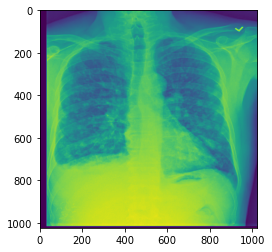

In [248]:
# with given index
import pydicom as dicom
import matplotlib.pylab as plt
imgIndex = 4
imgPath = trainSetImageMetadata[imgIndex]
imgPath = imgPath.imagePath()
ds = dicom.dcmread(imgPath)
plt.imshow(ds.pixel_array)

#### Preparing Dataset with patient id and respective image paths

In [249]:
from pandas.compat import StringIO
trainSetImageMetadata_df = pd.DataFrame(trainSetImageMetadata, columns=["Path"])
trainSetImageMetadata_df.head(2)

imageIdPaths = pd.DataFrame(columns=["patientId", "imgPath"])
imageIdPaths["patientId"] = trainSetImageMetadata_df["Path"].apply(getImgId)
imageIdPaths["imgPath"] = trainSetImageMetadata_df["Path"]

print("imageIdPaths", imageIdPaths.shape)
imageIdPaths.head(2)
print(imageIdPaths["imgPath"][2])
print((imageIdPaths["patientId"][2]))

imageIdPaths (26684, 2)
C:/Users/ashu/Downloads/rsna-pneumonia-detection-challenge/stage_2_train_images\000db696-cf54-4385-b10b-6b16fbb3f985.dcm
000db696-cf54-4385-b10b-6b16fbb3f985


# Exploratory Data Analysis on Train Labels and Detail Info CSV data sets

**Analyzing Detailed Classes CSV file**

Step 1 -> Define and read the Detail_Info CSV File 

In [250]:
classesPath =  dataDirPath + 'stage_2_detailed_class_info.csv'

detailedClasses = pd.read_csv(classesPath)

detailedClasses.head(2)

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal


Step 2 -> Check for Missing Values


In [251]:
detailedClasses.isna().apply(pd.value_counts)

,patientId,class
False,30227,30227


No Missing Values found

Step 3 -> Checking the shape of data frame

In [252]:
print("detailedClasses.shape : ", detailedClasses.shape)

# File has 30227 rows and 2 columns - PatientID & Class

detailedClasses.shape :  (30227, 2)


Step 3 -> Checking Unique Patients

In [253]:
print("Unique patientIds : ", detailedClasses['patientId'].nunique())

Unique patientIds :  26684


Total number of unique patients in data - 26684

**Observation - As we have total 30227 records and out of that 26684 are unique records, this shows presence of multiple records for some patients**

Step 4 -> Checking unique Classes

In [254]:
print("Unique patientIds : ", detailedClasses['class'].nunique(), )

print(detailedClasses['class'].unique)

Unique patientIds :  3
<bound method Series.unique of 0        No Lung Opacity / Not Normal
1        No Lung Opacity / Not Normal
2        No Lung Opacity / Not Normal
3                              Normal
4                        Lung Opacity
5                        Lung Opacity
6        No Lung Opacity / Not Normal
7        No Lung Opacity / Not Normal
8                        Lung Opacity
9                        Lung Opacity
10       No Lung Opacity / Not Normal
11                             Normal
12                             Normal
13                             Normal
14                       Lung Opacity
15                       Lung Opacity
16                       Lung Opacity
17                       Lung Opacity
18       No Lung Opacity / Not Normal
19                       Lung Opacity
20                       Lung Opacity
21                             Normal
22                       Lung Opacity
23                             Normal
24                       Lung Opac

3 Unique classes observed 
1 - No Lung Opacity/Not Normal,
2 - Normal,
3 - Lung Opacity

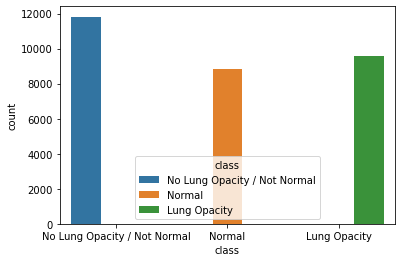

In [255]:
sns.countplot(x="class",hue="class",data=detailedClasses)

#### Analyzing Train Lables Dataset

Step 1 -> Reading the data 

In [256]:
labelsPath = dataDirPath + 'stage_2_train_labels.csv'

trainLabels = pd.read_csv(labelsPath)

trainLabels.head(2)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0


Step 2 -> Checking the missing values if any

In [257]:
trainLabels.isna().apply(pd.value_counts)

,patientId,x,y,width,height,Target
False,30227.0,9555,9555,9555,9555,30227.0
True,NaN,20672,20672,20672,20672,NaN


#### Observation - For around 20672 patients Bounding box cordinates not available where as for 9555 patients its avaialable

In [258]:
trainLabels[trainLabels['Target']==0].head(2)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0


Few records have observed with missing values in **x, y, width** and **height** coulmn, but no missing values observed in **patientId** and **Target**.

Also this is observed such missing columns are present for those records with **Target** as '0'.

**x, y, width** and **height** columns have the information for bounding boxes in Images where Penumonia is detected.

**Explaination on missing values - These are not the missing values instead it is expected not to have Bounding Box co-ordinates for those images where Pneumonia is not detected (Target - '0')**

Hence concluding there are no missing values in this dataset as well

Step 3 -> Checking unique Patients

In [259]:
print("Unique patientIds : ", trainLabels['patientId'].nunique(), )

Unique patientIds :  26684


Total Unique patients found - 26684

This is same as the number of patients in Detailed CSV sheet hence both sheets share the information for same patients

Step 4 -> Checkin unqiue Targets

In [260]:
print("Unique patientIds : ", trainLabels['Target'].nunique(), )

print("Unique patientIds : ", trainLabels['Target'].unique(), )

Unique patientIds :  2
Unique patientIds :  [0 1]


Trail label has only 2 target variables [0 & 1] 

**Conclusion - In Train labels only two target variables are present 0 & 1, where as in Detailed_Info sheet we have 3 classes.**

**As we have 3 Classes in Detailed_Info dataset and 2 Target Variables in Train_Labels, concatenating to get better insight into the data**

Step 1 -> Sorting both the datasets based on patientId

In [261]:
trainLabels.sort_values("patientId", inplace=True)
detailedClasses.sort_values("patientId", inplace=True)

Step 2 -> Concatenating the data

* To get the Target and classes into one dataframe

In [262]:
Combined_Data = pd.concat([trainLabels, detailedClasses["class"]], axis=1, sort=False)
Combined_Data.head(3)

,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
28989,000924cf-0f8d-42bd-9158-1af53881a557,NaN,NaN,NaN,NaN,0,Normal
28990,000db696-cf54-4385-b10b-6b16fbb3f985,316.0,318.0,170.0,478.0,1,Lung Opacity


**Validating the concatenation results**

In [263]:
Combined_Data.shape

(30227, 7)

In [264]:
Combined_Data.isna().apply(pd.value_counts)

,patientId,x,y,width,height,Target,class
False,30227.0,9555,9555,9555,9555,30227.0,30227.0
True,NaN,20672,20672,20672,20672,NaN,NaN


In [265]:
Combined_Data[Combined_Data["Target"] == 1].isna().apply(pd.value_counts)

,patientId,x,y,width,height,Target,class
False,9555,9555,9555,9555,9555,9555,9555


In [266]:
Combined_Data[Combined_Data["Target"] == 0].isna().apply(pd.value_counts)

,patientId,x,y,width,height,Target,class
False,20672.0,NaN,NaN,NaN,NaN,20672.0,20672.0
True,NaN,20672.0,20672.0,20672.0,20672.0,NaN,NaN


In [267]:
Combined_Data[Combined_Data["class"] == "Lung Opacity"].isna().apply(pd.value_counts)

,patientId,x,y,width,height,Target,class
False,9555,9555,9555,9555,9555,9555,9555


From Above Analysis our concatenated data is correct

## Prepare data for training


Step 1 -> 
* Convert data to only two classes, 'Normal' and 'Lung Opacity'
* Splitting the data in three parts, train, validation and test sets.
* Replace all 'NaN' values to zero(0)


In [268]:
# Conver data to only two classes, 'Normal' and 'Lung Opacity'
Combined_Data["class"].replace("No Lung Opacity / Not Normal", "Normal", inplace=True)
Combined_Data.head(3)

,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,Normal
28989,000924cf-0f8d-42bd-9158-1af53881a557,NaN,NaN,NaN,NaN,0,Normal
28990,000db696-cf54-4385-b10b-6b16fbb3f985,316.0,318.0,170.0,478.0,1,Lung Opacity


In [269]:

train_CombinedData = Combined_Data[0:15000]
validate_CombinedData = Combined_Data[15000:25000]
test_CombinedData = Combined_Data[25000:30227]

print("train_CombinedData.shape : ", train_CombinedData.shape)
print("validate_CombinedData.shape : ", validate_CombinedData.shape)
print("test_CombinedData.shape : ", test_CombinedData.shape)

print("\nunique train patients : ", train_CombinedData["patientId"].nunique())
print("unique validate patients : ", validate_CombinedData["patientId"].nunique())
print("unique test patients : ", test_CombinedData["patientId"].nunique())

print("\nTotal unique patients : ", imageIdPaths["patientId"].nunique())
print("Total of unique train and test : ", train_CombinedData["patientId"].nunique() + validate_CombinedData["patientId"].nunique() + test_CombinedData["patientId"].nunique())

print("\nLast from train set : ", train_CombinedData.iloc[14999]["patientId"])
print("First from validate set : ", validate_CombinedData.iloc[0]["patientId"])
print("\nLast from validate set : ", validate_CombinedData.iloc[9999]["patientId"])
print("First from test set : ", test_CombinedData.iloc[0]["patientId"])

# Set all NaN values to 0 in train and test data sets. While training NaN will not have any meaning.
#    * x, y, width and hight values as zero(0) means no bounding box.
train_CombinedData.fillna(0, inplace=True)
validate_CombinedData.fillna(0, inplace=True)
test_CombinedData.fillna(0, inplace=True)

train_CombinedData.shape :  (15000, 7)
validate_CombinedData.shape :  (10000, 7)
test_CombinedData.shape :  (5227, 7)

unique train patients :  13163
unique validate patients :  8601
unique test patients :  4920

Total unique patients :  26684
Total of unique train and test :  26684

Last from train set :  8a545321-245d-4e23-a4ca-634a90c5ba89
First from validate set :  8a546535-613f-49b1-897c-a0933c53cb84

Last from validate set :  d5cbd64c-322b-4460-ad0e-c9a23e781f3e
First from test set :  d5d0be71-4579-411a-9218-0f45a80df505


C:\Users\ashu\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [270]:
imageIdPaths.sort_values("patientId", inplace=True)

train_imageIdPaths = imageIdPaths[0:13163]
validate_imageIdPaths = imageIdPaths[13163:21764]
test_imageIdPaths = imageIdPaths[21764:26684]

print("train_imageIdPaths.shape : ", train_imageIdPaths.shape)
print("validate_imageIdPaths.shape : ", validate_imageIdPaths.shape)
print("test_imageIdPaths.shape : ", test_imageIdPaths.shape)

print("\nunique train patients : ", train_imageIdPaths["patientId"].nunique())
print("unique validate patients : ", validate_imageIdPaths["patientId"].nunique())
print("unique test patients : ", test_imageIdPaths["patientId"].nunique())

print("\nTotal unique patients : ", imageIdPaths["patientId"].nunique())
print("Total of unique train and test : ", train_imageIdPaths["patientId"].nunique() + validate_imageIdPaths["patientId"].nunique() + test_imageIdPaths["patientId"].nunique())

print("\nLast from train set : ", train_imageIdPaths.iloc[13162]["patientId"])
print("First from validate set : ", validate_imageIdPaths.iloc[0]["patientId"])
print("Last from validate set : ", validate_imageIdPaths.iloc[8600]["patientId"])
print("First from test set : ", test_imageIdPaths.iloc[0]["patientId"])

train_imageIdPaths.shape :  (13163, 2)
validate_imageIdPaths.shape :  (8601, 2)
test_imageIdPaths.shape :  (4920, 2)

unique train patients :  13163
unique validate patients :  8601
unique test patients :  4920

Total unique patients :  26684
Total of unique train and test :  26684

Last from train set :  8a545321-245d-4e23-a4ca-634a90c5ba89
First from validate set :  8a546535-613f-49b1-897c-a0933c53cb84
Last from validate set :  d5cbd64c-322b-4460-ad0e-c9a23e781f3e
First from test set :  d5d0be71-4579-411a-9218-0f45a80df505


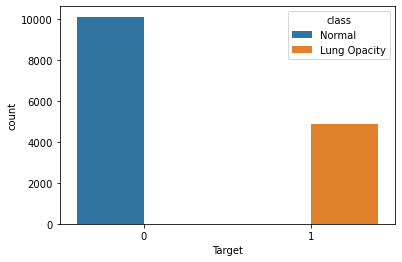

In [271]:
sns.countplot(x="Target",hue="class",data=train_CombinedData)

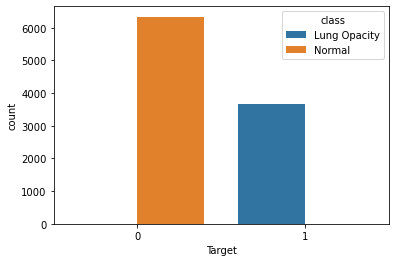

In [272]:
sns.countplot(x="Target",hue="class",data=validate_CombinedData)

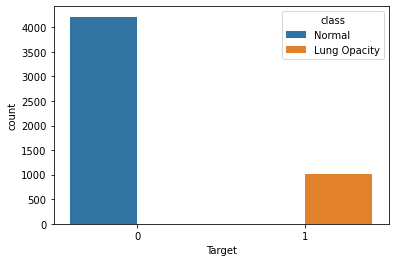

In [273]:
sns.countplot(x="Target",hue="class",data=test_CombinedData)

* Observation
    * train, validation and test sets are not well balanced. 
    * Images with 'Lung Opacity' are less in proportion in all these sets.

# Build UNet

### Constants

In [274]:
IMAGE_SIZE = 224

IMG_WIDTH = 1024
IMG_HEIGHT = 1024

TRAIN_BATCH_SIZE = 10
TEST_BATCH_SIZE = 10

ALPHA = 1.0

### Function and Class definations

In [275]:
# define iou or jaccard loss function
def iou_loss(y_true, y_pred):
    """Get Intersection over Union(IoU) ratio from ground truth and predicted masks.
    Arguments:
        y_true -- ground truth mask
        
        y_pred -- predicted mask
    """
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score

# mean iou as a metric
def mean_iou(y_true, y_pred):
    """Get mean Intersection over Union(IoU) ratio from ground truth and predicted masks.
    Arguments:
        y_true -- ground truth mask
        
        y_pred -- predicted mask
    """
    y_pred = tf.round(y_pred)    
    intersect = tf.reduce_sum(y_true * y_pred, axis=[1]) 
    union = tf.reduce_sum(y_true, axis=[1]) + tf.reduce_sum(y_pred, axis=[1])
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

In [276]:
def iouFromCoords(boxA, boxB) :
    """Get Intersection over Union(IoU) ratio from ground truth and predicted box coordinates.
    Arguments:
        boxA -- ground truth mask
        
        boxB -- predicted mask
    """
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = abs(max((xB - xA, 0)) * max((yB - yA), 0))
    if interArea == 0:
        return 0
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = abs((boxA[2] - boxA[0]) * (boxA[3] - boxA[1]))
    boxBArea = abs((boxB[2] - boxB[0]) * (boxB[3] - boxB[1]))

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou

In [277]:

def showMaskedImage(_imageSet, _maskSet, _index) :
    """To show image with imposing mask on it for the given index, form the given sets of images and masks.
    Arguments:
        _imageSet -- set of images
        
        _maskSet -- set of masks
        
        _index -- index of a set/collection
    """
    maskImage = _imageSet[_index]

    #pyplot.imshow(maskImage[:,:,0], cmap=pyplot.cm.bone)
    maskImage[:,:,0] = _maskSet[_index] * _imageSet[_index][:,:,0]
    maskImage[:,:,1] = _maskSet[_index] * _imageSet[_index][:,:,1]
    maskImage[:,:,2] = _maskSet[_index] * _imageSet[_index][:,:,2]

    pyplot.imshow(maskImage[:,:,0], cmap=pyplot.cm.bone)


In [278]:

class UNetTrainGenerator(Sequence):
    """Generator class to get data batches for training model. Extends Sequence class.
        
    Arguments:
        _imageIdPaths -- dataframe having patientId and image paths to load image for the patientId
        
        _CombinedData -- dataframe having patientId, image labels, target and class values combined together
        
        idx -- index of a batch
    """
    def __init__(self, _imageIdPaths, _CombinedData):       
        self.pids = _CombinedData["patientId"].to_numpy()
        self.imgIdPaths = _imageIdPaths
        self.coords = _CombinedData[["x", "y", "width", "height"]].to_numpy()
        # Resize Bounding box
        self.coords = self.coords * IMAGE_SIZE / IMG_WIDTH
        

    def __len__(self):
        return math.ceil(len(self.coords) / TRAIN_BATCH_SIZE)
    

    def __getitem__(self, idx): # Get a batch
        batch_coords = self.coords[idx * TRAIN_BATCH_SIZE:(idx + 1) * TRAIN_BATCH_SIZE] # Image coords
        batch_pids = self.pids[idx * TRAIN_BATCH_SIZE:(idx + 1) * TRAIN_BATCH_SIZE] # Image pids    
        
        batch_images = np.zeros((len(batch_pids), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
        batch_masks = np.zeros((len(batch_pids), IMAGE_SIZE, IMAGE_SIZE))
        for _indx, _pid in enumerate(batch_pids):
            _path = self.imgIdPaths[self.imgIdPaths["patientId"] == _pid]["imgPath"].array[0]
            _imgData = loadImage(str(_path)) # Read image
            img = _imgData.pixel_array 
            
            # Resize image
            resized_img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA)
    
            #print("batch_images[_indx] shape :", batch_images[_indx][:,:,0].shape)
            # preprocess image for the batch
            batch_images[_indx][:,:,0] = preprocess_input(np.array(resized_img[:,:], dtype=np.float32)) # Convert to float32 array
            batch_images[_indx][:,:,1] = preprocess_input(np.array(resized_img[:,:], dtype=np.float32)) # Convert to float32 array
            batch_images[_indx][:,:,2] = preprocess_input(np.array(resized_img[:,:], dtype=np.float32)) # Convert to float32 array  
            
            x = int(batch_coords[_indx, 0])
            y = int(batch_coords[_indx, 1])
            width = int(batch_coords[_indx, 2])
            height = int(batch_coords[_indx, 3])
            
            batch_masks[_indx][y:y+height, x:x+width] = 1
            
        # Returns images and ground truth masks for training
        return batch_images, batch_masks

In [279]:
# Generator for Predicting/Testing model
class UNetTestGenerator(Sequence):
    """Generator class to get data batches for testing model. Used to get batches of test data used for getting predictions.
        
    Arguments:
        _imageIdPaths -- dataframe having patientId and image paths to load image for the patientId
        
        _CombinedData -- dataframe having patientId, image labels, target and class values combined together
        
        idx -- index of a batch
    """
    def __init__(self, _imageIdPaths, _CombinedData):       
        self.pids = _CombinedData["patientId"].to_numpy()
        self.imgIdPaths = _imageIdPaths
        self.coords = _CombinedData[["x", "y", "width", "height", "Target"]].to_numpy() #for (1024, 1024)
        self.classes = _CombinedData["class"]
        # Resize Bounding box
        self.coordsOrig = self.coords #for (1024, 1024)
        self.coords = self.coords * IMAGE_SIZE / IMG_WIDTH   #for (224, 224)
        

    def __len__(self):
        # Returns total number of batches
        return math.ceil(len(self.coords) / TEST_BATCH_SIZE)
    

    def __getitem__(self, idx): # Get a batch
        batch_coords = self.coords[idx * TEST_BATCH_SIZE:(idx + 1) * TEST_BATCH_SIZE] # Image coords for (224, 224)
        batch_coordsOrig = self.coordsOrig[idx * TEST_BATCH_SIZE:(idx + 1) * TEST_BATCH_SIZE] # Image coords for (1024, 1024)
        batch_pids = self.pids[idx * TEST_BATCH_SIZE:(idx + 1) * TEST_BATCH_SIZE] # Image pids    
        batch_classes = self.classes[idx * TEST_BATCH_SIZE:(idx + 1) * TEST_BATCH_SIZE] # Image classes           
        
        batch_images = np.zeros((len(batch_pids), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
        batch_masks = np.zeros((len(batch_pids), IMAGE_SIZE, IMAGE_SIZE))
        for _indx, _pid in enumerate(batch_pids):
            _path = self.imgIdPaths[self.imgIdPaths["patientId"] == _pid]["imgPath"].array[0]
            _imgData = loadImage(str(_path)) # Read image
            img = _imgData.pixel_array 
            
            # Resize image
            resized_img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA) #(224, 224)
            #resized_img = cv2.resize(img[200:824, 200:824], dsize=(IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA)
    
            #print("batch_images[_indx] shape :", batch_images[_indx][:,:,0].shape)
            # preprocess image for the batch
            batch_images[_indx][:,:,0] = preprocess_input(np.array(resized_img[:,:], dtype=np.float32)) # Convert to float32 array
            batch_images[_indx][:,:,1] = preprocess_input(np.array(resized_img[:,:], dtype=np.float32)) # Convert to float32 array
            batch_images[_indx][:,:,2] = preprocess_input(np.array(resized_img[:,:], dtype=np.float32)) # Convert to float32 array  
            
            x = int(batch_coords[_indx, 0])
            y = int(batch_coords[_indx, 1])
            width = int(batch_coords[_indx, 2])
            height = int(batch_coords[_indx, 3])
            target = int(batch_coords[_indx, 4])
            
            batch_coords[_indx, 0] = x
            batch_coords[_indx, 1] = y 
            batch_coords[_indx, 2] = width 
            batch_coords[_indx, 3] = height    
            batch_coords[_indx, 4] = target 
            
            batch_masks[_indx][y:y+height, x:x+width] = 1

        # Returns images, ground truth masks, patientIds, resized-coordinates, class targets and ground truth coordinates/lables.   
        return batch_images, batch_masks, batch_pids, batch_coords, batch_classes, batch_coordsOrig  #for (224, 224) and (1024, 1024)

In [280]:

def create_UNetModel(trainable=True):
    """Function to create UNet architecture with MobileNet.
        
    Arguments:
        trainable -- Flag to make layers trainable. Default value is 'True'.
    """
    # Get all layers with 'imagenet' weights
    model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA, weights="imagenet") 
    # Top layer is last layer of the model
    
    # Make all layers trainable
    for layer in model.layers:
        layer.trainable = trainable

    # Add all the UNET layers here
    convLayer_112by112 = model.get_layer("conv_pw_1_relu").output
    convLayer_56by56 = model.get_layer("conv_pw_3_relu").output
    convLayer_28by28 = model.get_layer("conv_pw_5_relu").output
    convLayer_14by14 = model.get_layer("conv_pw_11_relu").output
    convLayer_7by7 = model.get_layer("conv_pw_13_relu").output
    # The last layer of mobilenet model is of dimensions (7x7x1024)

    # Start upsampling from 7x7 to 14x14 ...up to 224x224 to form UNET
    # concatinate with the original image layer of the same size from MobileNet
    x = Concatenate()([UpSampling2D()(convLayer_7by7), convLayer_14by14])
    x = Concatenate()([UpSampling2D()(x), convLayer_28by28])
    x = Concatenate()([UpSampling2D()(x), convLayer_56by56])
    x = Concatenate()([UpSampling2D()(x), convLayer_112by112])
    x = UpSampling2D(name="unet_last")(x) # upsample to 224x224

    # Add classification layer
    x = Conv2D(1, kernel_size=1, activation="sigmoid", name="masks")(x)
    x = Reshape((IMAGE_SIZE, IMAGE_SIZE))(x) 

    return Model(inputs=model.input, outputs=x)

### Create Generator instances for Train and Validation datasets

* These are further used in fit() method while training the model.

In [287]:
print(train_imageIdPaths.head())
print(train_CombinedData.head())

                              patientId  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6   
1  000924cf-0f8d-42bd-9158-1af53881a557   
2  000db696-cf54-4385-b10b-6b16fbb3f985   
3  000fe35a-2649-43d4-b027-e67796d412e0   
4  001031d9-f904-4a23-b3e5-2c088acd19c6   

                                             imgPath  
0  C:/Users/ashu/Downloads/rsna-pneumonia-detecti...  
1  C:/Users/ashu/Downloads/rsna-pneumonia-detecti...  
2  C:/Users/ashu/Downloads/rsna-pneumonia-detecti...  
3  C:/Users/ashu/Downloads/rsna-pneumonia-detecti...  
4  C:/Users/ashu/Downloads/rsna-pneumonia-detecti...  
                                  patientId      x      y  width  height  \
0      0004cfab-14fd-4e49-80ba-63a80b6bddd6    0.0    0.0    0.0     0.0   
28989  000924cf-0f8d-42bd-9158-1af53881a557    0.0    0.0    0.0     0.0   
28990  000db696-cf54-4385-b10b-6b16fbb3f985  316.0  318.0  170.0   478.0   
28991  000db696-cf54-4385-b10b-6b16fbb3f985  660.0  375.0  146.0   402.0   
28992  000fe35a-2649-43d4-b027-

#### visualize sample image with a mask to verify train generator instance 

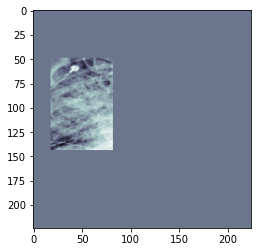

In [302]:
print(trainUNetDataGen)
trainUNetDataGen = UNetTrainGenerator(train_imageIdPaths, train_CombinedData)
validateUNetDataGen = UNetTrainGenerator(validate_imageIdPaths, validate_CombinedData)
imageSet0 = trainUNetDataGen[0][0]
maskSet0 = trainUNetDataGen[0][1]    
showMaskedImage(imageSet0, maskSet0, 5)

## Build UNet with MobileNet

* We start with a simple UNet architecture using MobileNet layers pretrained with 'imagenet' weights.

#### Train the Model

In [309]:
trainUnetModel = False

EPOCHS = 3
WEIGHTS_FILE = SAVED_FILES_ROOT + "UNetModel.h5"

adamOptimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
checkpoint = ModelCheckpoint("unetModel-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min", period=1)
stop = EarlyStopping( monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

UNetModel = create_UNetModel()
UNetModel.compile(loss=iou_loss, optimizer=adamOptimizer, metrics=[mean_iou]) 

UNetModel.load_weights(WEIGHTS_FILE) # train with saved weights

if trainUnetModel==True :
    # Make layers trainable
    for layer in UNetModel.layers:
        layer.trainable = True

    hist = UNetModel.fit_generator(generator=trainUNetDataGen,
                        epochs=EPOCHS,
                        validation_data=validateUNetDataGen,
                        callbacks=[checkpoint, reduce_lr, stop],
                        shuffle=True,
                        verbose=1)
    
    unet_history = np.array(hist.history)
    np.save("unetTrainHist-3", unet_history, allow_pickle=True)
    

ValueError: You are trying to load a weight file containing 15 layers into a model with 55 layers.

#### Plot training history curves

#### Visualize the UNet architecture

Ground Truth Box/Mask


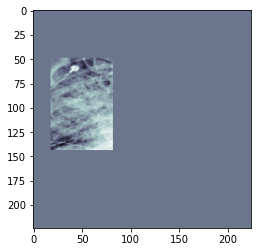

In [304]:
# Check sample ground truth masked image and predicted masked image 
imageSet0 = trainUNetDataGen[0][0]
maskSet0 = trainUNetDataGen[0][1]
print("Ground Truth Box/Mask")
showMaskedImage(imageSet0, maskSet0, 5)

Predicted Box/Mask


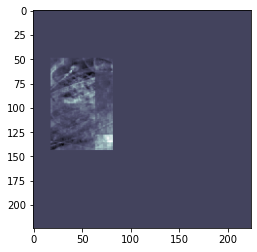

In [305]:
predMasks = UNetModel.predict(imageSet0)
print("Predicted Box/Mask")
showMaskedImage(imageSet0, predMasks, 5)

#### Predict the Test data set

In [308]:
predictUnetModel = False

if predictUnetModel == True :
    y_test, y_predicted = predictBatches(test_CombinedData, test_imageIdPaths, UNetModel)